## Instalación de dependencias

In [ ]:
# Install core libraries for text modeling and evaluation
%pip install sentence_transformers datasets matplotlib seaborn

# Install PyTorch nightly build for ROCm 6.3 (GPU support on AMD)
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/rocm6.3

# Install Accelerate for efficient training and device management
%pip install "accelerate>=0.26.0"

Looking in indexes: https://download.pytorch.org/whl/nightly/rocm6.3


## Importación de librerías

Esta sección carga todas las dependencias necesarias para el procesamiento de texto, entrenamiento del modelo y utilidades auxiliares.

In [ ]:
# Core utilities
import re
import random
import math
import csv
import gc
from datetime import datetime, timedelta

# Data handling
import pandas as pd
from datasets import load_dataset, DatasetDict

# Model and training components
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

# Similarity models
from sentence_transformers import SentenceTransformer, util

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# Optional: ensure plots render consistently
sns.set(style="whitegrid")


## Configuración del dispositivo (CPU / GPU)

In [ ]:
# Detect compute device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Dispositivo seleccionado: {device}")

# Optional: print GPU details when available
if device.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    gpu_cap = torch.cuda.get_device_capability(0)
    print(f"GPU: {gpu_name} — Compute Capability: {gpu_cap}")


Dispositivo seleccionado: cuda
GPU: Tesla T4 — Compute Capability: (7, 5)


## Parámetros y filtros de datos irrelevantes

En esta sección se definen patrones típicos de WhatsApp que deben ser descartados durante la limpieza del dataset.

In [ ]:
# Set of patterns considered irrelevant for training (WhatsApp system messages)
irrelevant_data = {
    # Spanish
    "eliminaste este mensaje",
    "se eliminó este mensaje",
    "<multimedia omitido>",
    "multimedia omitido",
    "los mensajes y las llamadas están cifrados de extremo a extremo",

    # English
    "you deleted this message",
    "this message was deleted",
    "<media omitted>",
    "media omitted",
    "messages and calls are end-to-end encrypted",
}

def contains_irrelevant_data(message: str) -> bool:
    """
    Returns True if the message contains any irrelevant WhatsApp system string.
    Assumes the input message has already been lowercased.
    """
    return any(pattern in message for pattern in irrelevant_data)


## Procesamiento del chat de WhatsApp

Esta celda contiene todas las funciones relacionadas con la limpieza, parseo y estructuración del chat de WhatsApp. No realiza acciones por sí misma; solo define el procesamiento que luego será utilizado por la interfaz interactiva.

In [ ]:
# ============================================================
# 4️⃣ PROCESAMIENTO DEL CHAT WHATSAPP (k-turns con roles)
# ============================================================

MSG_SEP = "<|msg_sep|>"   # separator between messages inside the same turn


def clean_text(text: str) -> str:
    """
    Apply light text cleaning: lowercase, trim, remove unusual symbols,
    normalize whitespace. This function does not decide whether a message
    is irrelevant; that is handled by `contains_irrelevant_data`.
    """
    text = text.lower().strip()
    text = re.sub(r"[^a-záéíóúñü0-9,.;:¡!¿?\s']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def parse_datetime(line: str):
    """
    Extract the datetime of a WhatsApp message line if present.
    Returns a datetime object or None if no valid timestamp is found.
    """
    match = re.match(r"(\d+/\d+/\d+[, ]\s?\d+:\d+)\s-", line)
    if match:
        for fmt in ("%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"):
            try:
                return datetime.strptime(match.group(1).replace(",", ""), fmt)
            except Exception:
                pass
    return None


def group_consecutive_messages(messages):
    """
    Group consecutive messages from the same author into a single turn
    if they are close in time.

    When several messages from the same author are grouped, the MSG_SEP
    token is inserted between them:

        msg_1 <|msg_sep|> msg_2 <|msg_sep|> msg_3
    """
    grouped = []
    for author, msg, ts in messages:
        if (
            grouped
            and grouped[-1][0] == author
            and ts and grouped[-1][2]
            and (ts - grouped[-1][2]) < timedelta(hours=1)
        ):
            # Same author and close in time → same turn with separator
            prev_author, prev_msg, prev_ts = grouped[-1]
            new_msg = prev_msg + f" {MSG_SEP} " + msg
            grouped[-1] = (author, new_msg, ts)
        else:
            grouped.append((author, msg, ts))
    return grouped


def process_whatsapp_chat_with_roles(
    filepath: str,
    target_author: str,
    k_history: int = 4,
    time_gap: timedelta = timedelta(hours=3),
):
    """
    Build <PROMPT, RESPONSE> pairs from a WhatsApp export.

    Turns are defined as consecutive messages from the same author,
    grouped when they are close in time.

    For each turn where `target_author` speaks, up to `k_history` previous
    turns (both authors) are used as context.

    Roles are made explicit as [target_author] / [OTRO] in the prompt, and messages
    inside each turn are separated by MSG_SEP (<|msg_sep|>).

    Final format:

        PROMPT   = "<|talk|><|ax1|> [OTRO] ... <|msg_sep|> ... [target_author] ... <|ax2|>"
        RESPONSE = " target_author_reply <|endoftext|>"
    """
    print("Procesando chat (k-turns con roles)...")

    # --- Read and parse raw lines ---
    messages = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            ts = parse_datetime(line)
            match = re.match(r"\d+/\d+/\d+[, ]\s?\d+:\d+\s-\s([^:]+):\s(.+)", line)
            if match:
                author = match.group(1).strip()
                raw_msg = match.group(2)
                msg = clean_text(raw_msg)
                # Filter empty messages or irrelevant WhatsApp system text
                if msg and not contains_irrelevant_data(msg):
                    messages.append((author, msg, ts))

    if not messages:
        print("No se encontraron mensajes válidos.")
        return [], []

    # --- Group consecutive messages from the same author (turns) ---
    messages = group_consecutive_messages(messages)
    print(f"Total de turnos agrupados: {len(messages)}")

    prompts, responses = [], []

    # --- Iterate over turns and build training pairs ---
    for i in range(1, len(messages)):
        author_i, msg_i, ts_i = messages[i]

        # We only care about turns where the target author is responding
        if author_i != target_author:
            continue

        # Build a context of up to k_history previous turns (both authors)
        context = []
        last_ts = ts_i

        for j in range(i - 1, -1, -1):
            a_j, m_j, ts_j = messages[j]

            # Session break if the time gap is too large
            if ts_j and last_ts and (last_ts - ts_j) > time_gap:
                break

            # Insert at the beginning to keep chronological order
            context.insert(0, (a_j, m_j))
            last_ts = ts_j if ts_j is not None else last_ts

            if len(context) >= k_history:
                break

        if not context:
            continue

        def fmt_turn(a, m):
            speaker = f"[{target_author}]" if a == target_author else "[OTRO]"
            return f"{speaker} {m}"

        context_str = " ".join(fmt_turn(a, m) for (a, m) in context)

        prompt = f"<|talk|><|ax1|> {context_str} <|ax2|>"
        response = f" {msg_i} <|endoftext|>"

        prompts.append(prompt)
        responses.append(response)

    print(f"Total de pares generados: {len(prompts)}")
    return prompts, responses


## Procesamiento interactivo del chat
Esta celda ofrece una interfaz interactiva para cargar el archivo del chat, ingresar el nombre del autor y ajustar parámetros como el historial considerado y el tiempo máximo entre mensajes. Permite procesar el chat sin modificar código.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# File upload widget for WhatsApp chat export (.txt)
chat_uploader = widgets.FileUpload(
    accept=".txt",
    multiple=False,
    description="Subir chat (.txt)"
)

# Text input for the target author (exactly as appears in the export)
author_input = widgets.Text(
    description="Autor:",
    placeholder="Nombre exactamente como figura en el chat",
    layout=widgets.Layout(width="60%")
)

# Slider for the number of history turns
k_history_slider = widgets.IntSlider(
    value=4,
    min=1,
    max=10,
    step=1,
    description="k_history:",
    continuous_update=False
)

# Slider for the time gap (in hours) to cut sessions
time_gap_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=24,
    step=1,
    description="time_gap (h):",
    continuous_update=False
)

# Button to trigger processing
process_button = widgets.Button(
    description="Procesar chat",
    button_style="primary"
)

output_proc = widgets.Output()


def on_process_clicked(_):
    with output_proc:
        clear_output()

        # Basic validation
        if len(chat_uploader.value) == 0:
            print("Por favor, sube un archivo de chat en formato .txt.")
            return

        target_author = author_input.value.strip()
        if not target_author:
            print("Por favor, ingresa el nombre del autor exactamente como aparece en el chat.")
            return

        # Extract uploaded file content
        upload_info = next(iter(chat_uploader.value.values()))
        content = upload_info["content"].decode("utf-8")

        # Save to temporary file so we can reuse the existing function
        tmp_path = "uploaded_chat.txt"
        with open(tmp_path, "w", encoding="utf-8") as f:
            f.write(content)

        # Call the processing function and expose results as global variables
        global prompts, responses
        prompts, responses = process_whatsapp_chat_with_roles(
            filepath=tmp_path,
            target_author=target_author,
            k_history=k_history_slider.value,
            time_gap=timedelta(hours=time_gap_slider.value),
        )

        print(f"Pares generados: {len(prompts)}")
        if prompts:
            print("\nEjemplo de PROMPT:")
            print(prompts[0][:500] + ("..." if len(prompts[0]) > 500 else ""))
            print("\nEjemplo de RESPONSE:")
            print(responses[0][:500] + ("..." if len(responses[0]) > 500 else ""))
        print("\nVariables disponibles para las siguientes celdas: 'prompts', 'responses'.")


process_button.on_click(on_process_clicked)

display(
    widgets.VBox([
        widgets.HTML("<b>Procesamiento interactivo del chat de WhatsApp</b>"),
        chat_uploader,
        author_input,
        k_history_slider,
        time_gap_slider,
        process_button,
        output_proc
    ])
)


## Creación del dataset, limpieza y guardado

Esta celda toma las listas prompts y responses generadas previamente, construye un DataFrame, aplica una limpieza básica (elimina ejemplos triviales y enlaces) y guarda un archivo CSV con el dataset inicial. Además, muestra algunos ejemplos aleatorios para inspeccionar el resultado.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Safety check: prompts and responses must exist
if "prompts" not in globals() or "responses" not in globals():
    raise RuntimeError(
        "Las variables 'prompts' y 'responses' no existen. "
        "Ejecuta primero el procesamiento interactivo del chat (sección 4-bis)."
    )

def build_dataset(prompts, responses,
                  min_prompt_len: int = 4,
                  min_response_len: int = 3,
                  filter_links: bool = True):
    """
    Build a DataFrame from prompts and responses applying basic cleaning:
    - Drop NaN values.
    - Remove very short prompts/responses.
    - Optionally filter out examples containing URLs.
    """
    df = pd.DataFrame({"prompt": prompts, "response": responses}).dropna()

    # Filter trivial examples (very short prompts/responses)
    df = df[
        (df["prompt"].str.split().str.len() >= min_prompt_len) &
        (df["response"].str.split().str.len() >= min_response_len)
    ].reset_index(drop=True)

    # Basic noise filtering: remove URLs if requested
    if filter_links:
        df = df[
            ~df["prompt"].str.contains(r"http|www|\.com", regex=True) &
            ~df["response"].str.contains(r"http|www|\.com", regex=True)
        ].reset_index(drop=True)

    return df


# Default parameters (aligned with your original thresholds)
min_prompt_len_default = 4
min_response_len_default = 3
filter_links_default = True
output_path_default = "train_data_raw.csv"

# Build dataset with default configuration
data = build_dataset(
    prompts,
    responses,
    min_prompt_len=min_prompt_len_default,
    min_response_len=min_response_len_default,
    filter_links=filter_links_default,
)

# Save preprocessed dataset
output_path = output_path_default
data.to_csv(output_path, index=False, quoting=csv.QUOTE_ALL)

print(f"Dataset inicial guardado → {len(data)} pares.")
print("\nVista aleatoria de algunos ejemplos:\n")
for _ in range(min(5, len(data))):
    s = data.sample(1).iloc[0]
    print(f"Prompt:\n{s['prompt']}\n→ Response:\n{s['response']}\n{'-'*70}")

Dataset inicial guardado → 21449 pares.

Vista aleatoria de algunos ejemplos:

Prompt:
<|talk|><|ax1|> [Nico Bazan] ya la vengo teniendo en base de datos, arquitectura [OTRO] pero ya el 7 lo leo y es muy wtf [Nico Bazan] es siempre asi <|msg_sep|> no se como sabe tanto [OTRO] si la tuve en otra materia <|msg_sep|> si posta... si no se saca un 10 yo ya no creo en nadie <|msg_sep|> hay q hacernos amigos de ella ahre <|ax2|>
→ Response:
 igual tengo mis dudas con el 5, lo voy a preguntar despues <|endoftext|>
----------------------------------------------------------------------
Prompt:
<|talk|><|ax1|> [Nico Bazan] jajaja <|msg_sep|> me quiero pegar un tiro [OTRO] same <|msg_sep|> pero bueno <|msg_sep|> no vale la pena es una materia nomas <|msg_sep|> null [Nico Bazan] jajajajja <|msg_sep|> mal <|msg_sep|> de que filminas es eso [OTRO] la de datos no estructurados <|ax2|>
→ Response:
 ah, no la vi muy bien <|msg_sep|> te esta sirviendo? <|endoftext|>
--------------------------------------

## Filtrado semántico global

Esta celda aplica un filtrado semántico basado en embeddings para quedarse únicamente con pares prompt–response que tengan una relación de significado suficientemente fuerte. Se calcula la similitud coseno entre cada prompt y su respuesta, se agregan estos valores al DataFrame y se guarda un dataset filtrado.

In [ ]:
# Load the sentence transformer model (only once)
if "model_emb" not in globals():
    model_emb = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Encode prompts and responses
emb_prompts = model_emb.encode(
    data["prompt"].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)
emb_resps = model_emb.encode(
    data["response"].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)

# Cosine similarity between each prompt and its paired response
similarities = util.cos_sim(emb_prompts, emb_resps).diagonal().cpu().numpy()
data["similarity"] = similarities

print(f"Media de similitud: {data['similarity'].mean():.3f}")

# Filtering configuration
SIM_THRESHOLD = 0.30
MAX_PROMPT_LEN = 600
MAX_RESPONSE_LEN = 400

# Keep only examples with strong semantic relation and reasonable length
filtered = data[
    (data["similarity"] > SIM_THRESHOLD) &
    (data["prompt"].str.len() < MAX_PROMPT_LEN) &
    (data["response"].str.len() < MAX_RESPONSE_LEN)
].reset_index(drop=True)

output_filtered_path = "filtered_train_data.csv"
filtered.to_csv(output_filtered_path, index=False)

print(f"Dataset final guardado en '{output_filtered_path}'.")
print(f"Total de pares útiles: {len(filtered)} (de {len(data)}).")

# Quick preview of filtered examples
print("\nVista rápida de algunos ejemplos filtrados:\n")
for _ in range(min(3, len(filtered))):
    s = filtered.sample(1).iloc[0]
    print(
        f"Prompt:\n{s['prompt']}\n"
        f"→ Response:\n{s['response']}\n"
        f"Similarity: {s['similarity']:.3f}\n"
        + "-" * 70
    )

Batches:   0%|          | 0/671 [00:00<?, ?it/s]

Batches:   0%|          | 0/671 [00:00<?, ?it/s]

Media de similitud: 0.495
Dataset final guardado en 'filtered_train_data.csv'.
Total de pares útiles: 18539 (de 21449).

Vista rápida de algunos ejemplos filtrados:

Prompt:
<|talk|><|ax1|> [OTRO] buen dia!! <|ax2|>
→ Response:
 buen día! <|endoftext|>
Similarity: 0.774
----------------------------------------------------------------------
Prompt:
<|talk|><|ax1|> [Nico Bazan] hmm <|msg_sep|> eso es relativo jajaja <|msg_sep|> no todos estamos trabajando equitativamentr <|msg_sep|> no sé si falta mucho pero bueno [OTRO] claro [Nico Bazan] si no hay q buscar trabajo de otra cosa aj <|msg_sep|> vi q hay unos de transcribir <|msg_sep|> home office [OTRO] sipp <|msg_sep|> hay uno de una empresa llamada appen q esta bueno parecee <|msg_sep|> quizas es el que viste vos jaja <|ax2|>
→ Response:
 ni idea jaja <|msg_sep|> yo decía en general <|msg_sep|> creo q hay varios lugares <|msg_sep|> para tener en cuenta ? <|endoftext|>
Similarity: 0.695
---------------------------------------------------

## Carga del modelo base o fine-tune anterior

Esta celda carga el modelo base seleccionado, inicializa el tokenizer, registra los tokens especiales utilizados en el formato de conversación y ajusta las dimensiones del modelo para incluirlos. Finalmente, mueve el modelo al dispositivo correspondiente (CPU o GPU).

In [ ]:
# ============================================================
# 7️⃣ CARGA DEL MODELO BASE O FINE-TUNE ANTERIOR
# ============================================================
model_name = "DeepESP/gpt2-spanish"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Register special tokens used in the conversational format
special_tokens = {
    "additional_special_tokens": [MSG_SEP, f"[{author_input.value.strip()}]", "[OTRO]"]
}
tokenizer.add_special_tokens(special_tokens)

# Padding token (GPT-2 uses EOS as pad)
tokenizer.pad_token = tokenizer.eos_token

# Load base model
model = AutoModelForCausalLM.from_pretrained(model_name)

# Resize embeddings to include new special tokens
model.resize_token_embeddings(len(tokenizer))

# Move model to CPU/GPU
model.to(device)

print(f"Modelo cargado: {model_name}")
print(f"Total de tokens en el tokenizer: {len(tokenizer)}")
print(f"Ejecutando en: {device}")


Modelo cargado: DeepESP/gpt2-spanish
Total de tokens en el tokenizer: 50260
Ejecutando en: cuda


## Tokenización robusta para entrenamiento

Esta celda carga el dataset filtrado, separa los datos en entrenamiento y validación, y construye una función de tokenización adecuada para entrenamiento causal (SFT). Cada ejemplo se tokeniza de manera independiente (sin concatenación), y las etiquetas (labels) corresponden directamente a los input_ids.

In [ ]:
# Load and clean dataset
data = pd.read_csv("filtered_train_data.csv")
data = data.dropna(subset=["prompt", "response"])
data = data[(data["prompt"].str.strip() != "") & (data["response"].str.strip() != "")]
data.to_csv("filtered_train_data.csv", index=False)

# Load into HuggingFace dataset structure
dataset = load_dataset("csv", data_files="filtered_train_data.csv")

# Split into train/validation
train_test = dataset["train"].train_test_split(test_size=0.2)
datasets = DatasetDict({
    "train": train_test["train"],
    "validation": train_test["test"],
})

def tokenize_function(examples):
    """
    Tokenizes each pair (prompt, response) as a single training example.
    The full conversational formatted text is already built in the dataset.
    Labels are set equal to input_ids for causal LM training.
    """
    texts = []
    for p, r in zip(examples["prompt"], examples["response"]):
        if isinstance(p, str) and isinstance(r, str):
            texts.append(f"{p.strip()} {r.strip()}")

    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=256,
    )

    # Causal LM: labels = input_ids
    encodings["labels"] = encodings["input_ids"].copy()
    return encodings

# Apply tokenization
tokenized = datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["prompt", "response"],
)

lm_datasets = tokenized
print(lm_datasets)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14831 [00:00<?, ? examples/s]

Map:   0%|          | 0/3708 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['similarity', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14831
    })
    validation: Dataset({
        features: ['similarity', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3708
    })
})


## Argumentos de entrenamiento

Define los hiperparámetros principales de entrenamiento para el fine-tuning del modelo (número de épocas, batch size, tasa de aprendizaje, etc.).

In [ ]:
training_args = TrainingArguments(
    output_dir="./nico-bot",
    num_train_epochs=3,              # few epochs for a final refinement
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,              # small LR to preserve base style
    save_strategy="epoch",
    eval_strategy="no",        # no evaluation during training
    logging_steps=10,
    report_to=[],                    # disable external loggers
)

## Configuración del Trainer

Configura el objeto Trainer que orquesta el loop de entrenamiento, conectando el modelo, los datos tokenizados y los argumentos de entrenamiento. Se usa el DataCollatorForLanguageModeling en modo causal (sin MLM).

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,   # causal LM, not masked LM
    ),
)

## Entrenamiento y guardado del modelo

Esta celda entrena el modelo y guarda los pesos y el tokenizer en un directorio cuyo nombre se genera automáticamente en función del autor seleccionado en la etapa de procesamiento interactivo.


In [ ]:
# Build dynamic save directory from author_input
if "author_input" in globals():
    author_name = author_input.value.strip()
    # Normalize folder name: replace spaces, remove symbols
    safe_author = re.sub(r"[^A-Za-z0-9_-]", "_", author_name)
    save_dir = f"./bot_{safe_author}" if safe_author else "./bot_model"
else:
    save_dir = "./bot_model"

print(f"Guardando el modelo en: {save_dir}")

try:
    trainer.train()
finally:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# Save model and tokenizer
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Modelo y tokenizer guardados en: {save_dir}")


Guardando el modelo en: ./bot_Nico_Bazan


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,6.908500
20,6.287500
30,5.910100
40,5.701300
50,5.492700
60,5.382500
70,5.284800
80,5.188800
90,5.168900
100,5.066200


Modelo y tokenizer guardados en: ./bot_Nico_Bazan


## Comparador de respuestas entre modelos

Esta celda carga el modelo base y el modelo fine-tuneado, y define un comparador para generar respuestas con ambos a partir de un mismo prompt. De esta forma se puede inspeccionar cualitativamente el efecto del fine-tuning.

In [ ]:
# Ensure save_dir exists (from training step)
if "save_dir" not in globals():
    save_dir = "./bot_model"  # fallback directory if not defined

# Build author tag used during preprocessing and training
if "author_input" in globals() and author_input.value.strip():
    AUTHOR_TAG = f"[{author_input.value.strip()}]"
else:
    AUTHOR_TAG = "[NICO]"  # default fallback

# Load base model with the same tokenizer (must match special tokens)
base_model = AutoModelForCausalLM.from_pretrained("DeepESP/gpt2-spanish")
base_model.resize_token_embeddings(len(tokenizer))
base_model.to(device)
base_model.eval()

# Load fine-tuned model
fine_model = AutoModelForCausalLM.from_pretrained(save_dir).to(device)
fine_model.eval()


def generate_response(
    prompt: str,
    model,
    tokenizer,
    max_new_tokens: int = 60
) -> str:
    """
    Generate a response following the conversational format used during training.
    The input prompt is plain text from the user (no tags).
    The model should interpret it as a message from the other participant.
    """

    # Construct formatted input according to training structure
    formatted_prompt = (
        f"<|talk|><|ax1|> [OTRO] {prompt.strip()} <|ax2|> {AUTHOR_TAG} "
    )

    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.8,
        top_p=0.92,
        repetition_penalty=1.9,
        no_repeat_ngram_size=3,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Truncate at end-of-text tag if present
    if "<|endoftext|>" in generated:
        generated = generated.split("<|endoftext|>")[0]

    # Keep only text after <|ax2|>
    if "<|ax2|>" in generated:
        generated = generated.split("<|ax2|>", 1)[-1].strip()

    # Remove role tags and internal separators from visible output
    generated = generated.replace(AUTHOR_TAG, "")
    generated = generated.replace("[OTRO]", "")
    generated = generated.replace(MSG_SEP, " ")

    # Final whitespace cleanup
    response = re.sub(r"\s+", " ", generated).strip()
    return response if response else "(no generated response)"


def compare_models(prompt: str):
    """Generate and print responses from both models for comparison."""
    print(f"\nPrompt: {prompt}")
    base_resp = generate_response(prompt, base_model, tokenizer)
    fine_resp = generate_response(prompt, fine_model, tokenizer)

    print("\n----------------------------------")
    print("Base model:\n", base_resp)
    print("----------------------------------")
    print("Fine-tuned model:\n", fine_resp)
    print("----------------------------------")


# Extract prompts from validation set and sample a few
val_prompts = [ex["prompt"] for ex in datasets["validation"]]
sample_prompts = random.sample(val_prompts, min(5, len(val_prompts)))

print("\n=== Model comparison using validation samples ===")
for q in sample_prompts:
    # Remove framework tags and internal separators
    clean_q = (
        q.replace("<|talk|>", "")
         .replace("<|ax1|>", "")
         .replace("<|ax2|>", "")
         .replace("<|endoftext|>", "")
         .replace(MSG_SEP, " ")
         .replace(AUTHOR_TAG, "")
         .replace("[OTRO]", "")
         .strip()
    )
    compare_models(clean_q)



=== Model comparison using validation samples ===

Prompt: me mataste xd   pero ya te quedas a vivir sola  significa bien hecho!!   siempre me pone eso cuando me corrige las tareas   claro   supongo que si no voy a esperar un tiempo mas a ver si hay noticias sobre los finales  aaah jjaja   gracias ?   pero igual tener q venir para los finales ?   a no ser q sean virtuales  por eso osea

----------------------------------
Base model:
 ` es bueno saber algo. En fin, ¡pues aquí está! ... la verdad... en mi caso tampoco creo tanto? —Si el mundo lo supiese todo de repente, ¿por qué iba yo tan nerviosa con mis cosas? —dijo muy seria—. Ahora mismo tengo muchos conocidos y necesito
----------------------------------
Fine-tuned model:
 seguro en breve tenes la reunión de nuevo? o como quieras ir hoy y contarme todo lo del otro dia, aunque sea una cosa jajq samee mmmsi es tarde también ahre! yo tampoco tengo ni idea cómo hacer el trabajo creo que
----------------------------------

Prompt: si p

## Chat interactivo

Esta celda permite interactuar con el modelo fine-tuneado mediante entrada por consola. El usuario puede escribir mensajes y recibir respuestas del modelo. Para finalizar la sesión, ingresar salir.

In [ ]:
def clean_user_input(text: str) -> str:
    """Remove training tags from user input to avoid formatting conflicts."""
    text = text.replace("<|talk|>", "")
    text = text.replace("<|ax1|>", "")
    text = text.replace("<|ax2|>", "")
    text = text.replace("<|endoftext|>", "")
    text = text.replace(MSG_SEP, " ")
    text = text.replace(AUTHOR_TAG, "")
    text = text.replace("[OTRO]", "")
    return text.strip()

print("=== Interactive chat with the fine-tuned model ===")
print("(Type 'salir' to exit)\n")

while True:
    user_msg = input("You: ").strip()

    if user_msg.lower() == "salir":
        print("Model: session finished.")
        break

    # Remove unwanted tags and tokens
    user_msg = clean_user_input(user_msg)

    # Generate model response
    response = generate_response(user_msg, fine_model, tokenizer)
    print(f"Model: {response}\n")




=== Interactive chat with the fine-tuned model ===
(Type 'salir' to exit)

You: Holaa
Model: cómo estás? 64 bienn vos?? que tal como te fue en la clase xd track jajajq ñoquissimo! ? órdoba samee. comi un poquito y me fui a dormir, ahora estoy re cansada de ver videos con mi mama :c

You: Todo bien por siuerte, como te fue en el parcial?
Model: todo lindo y me alegro de que tengas noticias del profe xd ya terminaste la clase ? yo no sé dónde se encuentra ahora jajajqahah bueno mañana a las 16 creo q voy para allá ahi pero bueno al menos le pregunte algo sobre mí familia o eso

You: me tengo q ir
Model: no sé que es una vuelta? jajajq andamos yendo a comer y comiendo o algo asi xd mal pero creo saber si podemos hacer las cosas bien en un rato. eso de estar con alguien siempre anda por ahí entonces ? el problema son los amigos ugggg para

You: bueno chauu
Model: pero igual no te gusta xd, como estás? de una ? ndea y sara se ponen a estudiar con ellos jajajqa random esta horribleo ni idea 

## Evaluación cuantitativa y reporte final

Esta celda evalúa cuantitativamente el modelo base y el modelo fine-tuneado sobre el conjunto de validación. Se calcula la pérdida media de cross-entropy y la perplexity aproximada, y se reporta la mejora relativa del modelo fine-tuneado. Finalmente, se muestra una comparación gráfica sencilla entre ambos modelos.

Evaluando...:   5%|▌         | 200/3708 [00:04<01:17, 45.14it/s]



Resultados de evaluación:
Base model  → Cross-Entropy: 7.545 | Perplexity: 1892.15
Fine-tuned  → Cross-Entropy: 6.168 | Perplexity: 477.03
Mejora relativa en perplexity: 74.79%


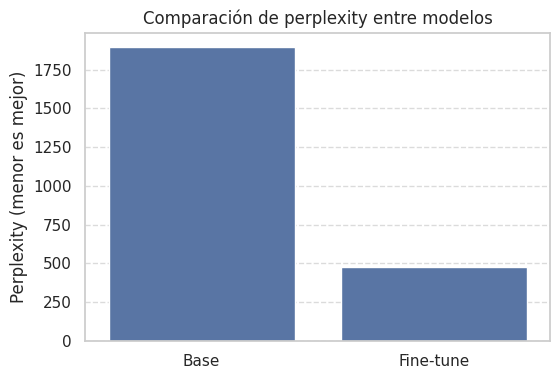

In [ ]:
def evaluate_model(model, dataset, max_batches: int = 200):
    """
    Evaluate a causal language model on a subset of the dataset.

    The function computes the average cross-entropy loss and derives
    perplexity as exp(loss). It iterates over individual examples,
    feeding input_ids as both inputs and labels.
    """
    model.eval()
    losses = []

    with torch.no_grad():
        for i, example in enumerate(tqdm(dataset, desc="Evaluando...")):
            if i >= max_batches:
                break

            input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(device)
            outputs = model(input_ids, labels=input_ids)
            losses.append(outputs.loss.item())

    avg_loss = sum(losses) / len(losses)
    try:
        perp = math.exp(avg_loss)
    except OverflowError:
        perp = float("inf")

    return {"cross_entropy": avg_loss, "perplexity": perp}


# Evaluate base and fine-tuned models on the validation set
metrics_base = evaluate_model(base_model, lm_datasets["validation"])
metrics_fine = evaluate_model(fine_model, lm_datasets["validation"])

print("\nResultados de evaluación:")
print(
    f"Base model  → Cross-Entropy: {metrics_base['cross_entropy']:.3f} | "
    f"Perplexity: {metrics_base['perplexity']:.2f}"
)
print(
    f"Fine-tuned  → Cross-Entropy: {metrics_fine['cross_entropy']:.3f} | "
    f"Perplexity: {metrics_fine['perplexity']:.2f}"
)

# Relative improvement in perplexity (percentage)
improvement = (
    (metrics_base["perplexity"] - metrics_fine["perplexity"])
    / metrics_base["perplexity"]
    * 100
)

print(f"Mejora relativa en perplexity: {improvement:.2f}%")

# Simple barplot comparison
plt.figure(figsize=(6, 4))
sns.barplot(
    x=["Base", "Fine-tune"],
    y=[metrics_base["perplexity"], metrics_fine["perplexity"]],
)
plt.title("Comparación de perplexity entre modelos")
plt.ylabel("Perplexity (menor es mejor)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
